Title: Calibration of the SOLEIL CRISTAL beamline Mythen Banana

Authors: 
Jerome Kieffer <kieffer@esrf.eu>
Frederic-Emmanuel Picca <picca@synchrotron-soleil.fr>

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyFAI, fabio, h5py
from scipy.signal import find_peaks_cwt
from numpy import array

from soleil import *

In [3]:
ROOT = "/home/experiences/instrumentation/picca/Downloads"
PUBLISHED = ROOT

In [4]:
#h5f = h5py.File("tth2C-17_11_08-49-12_011.nxs")
h5f = h5py.File(os.path.join(ROOT, "tth2C-16_11_15-55-22_008.nxs"))
ds = h5f["a/scan_data/data_01"]
ac = h5f["a/scan_data/actuator_1_1"][...]
print(ds.shape)
print(ac)

(26, 2560)
[  74.99994445   76.00000001   77.00005556   78.00000001   79.00005556
   80.00022223   81.00011112   82.00005556   83.00005556   84.00000001
   85.00016667   86.00005556   87.00000001   88.00005556   89.00000001
   90.00000001   91.00033334   92.00011112   93.00005556   94.00005556
   95.00000001   96.00000001   97.00005556   98.00022223   99.00005556
  100.00000001]


<IPython.core.display.Javascript object>


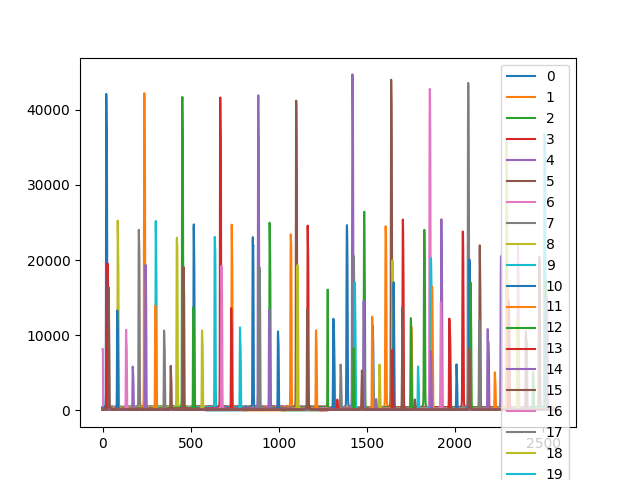

0 [(1388, 23916)]
1 [(1608, 24067)]
2 [(1827, 23352)]
3 [(2045, 23775)]
4 [(1420, 42039), (2263, 19751)]
5 [(1640, 40537), (2480, 19975)]
6 [(1859, 39351)]
7 [(208, 22350), (1427, 19098), (2077, 40802)]
8 [(423, 22056), (1647, 18706), (2294, 34867)]
9 [(639, 21671), (1314, 10273), (1866, 17668), (2511, 34534)]
10 [(23, 37980), (854, 21693), (1535, 9919), (2084, 18331)]
11 [(239, 38648), (1070, 21937), (1754, 9919), (2301, 15579)]
12 [(454, 39965), (1277, 16063), (1486, 24622), (1972, 10430), (2518, 15521)]
13 [(30, 17803), (670, 38320), (1706, 23486), (2190, 8404)]
14 [(246, 16988), (885, 38847), (1483, 13487), (1925, 22294), (2407, 8303)]
15 [(461, 17534), (1101, 38243), (1703, 13049), (2142, 20382)]
16 [(136, 8894), (677, 17017), (1922, 12324), (2359, 20219)]
17 [(351, 9555), (892, 17631), (1353, 5223), (2140, 10448)]
18 [(88, 22311), (567, 9374), (1108, 17307), (1573, 5451), (2357, 10452)]
19 [(304, 21262), (782, 9440), (1433, 15983), (1792, 5192)]
20 [(85, 12327), (519, 22262), (99

In [5]:
fig, ax = subplots()
for idx, crv in enumerate(ds):
    ax.plot(crv, label=str(idx))
    print(idx, [(i,crv[i]) for i in find_peaks_cwt(crv, array([20])) if crv[i]>1200])
    #if idx>5:
    #    break
ax.legend()

<IPython.core.display.Javascript object>


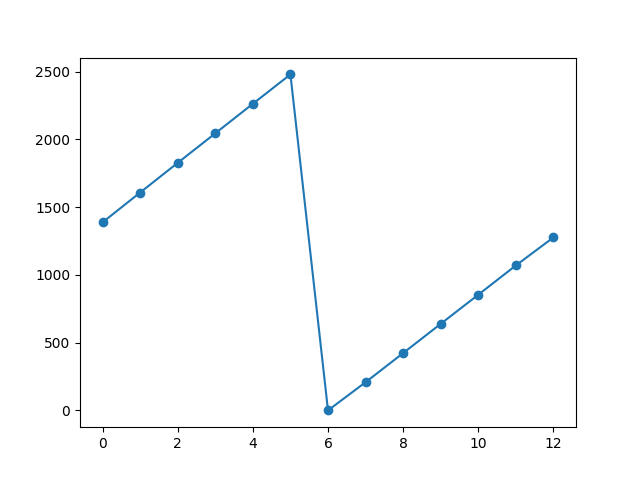

In [6]:
from scipy.stats import linregress
peak_0 = numpy.array([0,1388,1,1608,2,1827,3,2045,4,2263,5,2480,6,0,7,208,8,423,9,639,10,854,11,1070,12,1277]).reshape((-1,2))
fig, ax = subplots()
ax.plot(peak_0[:,0], peak_0[:,1], 'o-')

In [7]:
r_1 = linregress(peak_0[:6, 0], peak_0[:6, 1])
r_2 = linregress(peak_0[7:, 0], peak_0[7:, 1])

print(r_1)
print(r_2)

LinregressResult(slope=218.37142857142857, intercept=1389.2380952380954, rvalue=0.9999973523091058, pvalue=1.0515391326314286e-11, stderr=0.25125535158184004)
LinregressResult(slope=214.31428571428569, intercept=-1290.8190476190475, rvalue=0.9999794076094084, pvalue=6.3606545934946318e-10, stderr=0.68769555042439334)


In [8]:
print((r_1.intercept - r_2.intercept) * 2 / (r_1.slope + r_2.slope))


12.3880084522


In [9]:
from pyFAI.detectors import Mythen

class DoubleMythen(Mythen):
    MAX_SHAPE = (1, 1280*2)
    aliases = ["Double Mythen 2580"]
mythen_a = DoubleMythen() #left
mythen_b = DoubleMythen() #right

mythen_a.mask = numpy.atleast_2d(numpy.array([i>=1280 for i in range(1280*2)], dtype=numpy.int8))
mythen_b.mask = numpy.atleast_2d(numpy.array([i<1280 for i in range(1280*2)], dtype=numpy.int8))

In [10]:
mythen_a

Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m

In [11]:
from pyFAI.goniometer import GeometryTransformation, GoniometerRefinement, GeometryRefinement
from pyFAI.peak_picker import ControlPoints, PointGroup
from pyFAI.calibrant import get_calibrant
wavelength = 0.67186e-10
distance = 0.617400891837
transfo = GeometryTransformation(param_names=["dist", "poni1", "poni2", "scale1", "scale2", "offset1", "offset2", "rot3"],
                                 pos_names=["angle"],
                                 dist_expr="dist",
                                 poni1_expr="poni1",
                                 poni2_expr="poni2",
                                 rot1_expr="pi*(angle * scale1 + offset1)/180",
                                 rot2_expr="pi*(angle * scale2 + offset2)/180",
                                 rot3_expr="rot3")
bounds = {"dist": (distance, distance),
          "poni1": (-0.1, 0.1),
          "poni2": (0, 0),
          "scale1": (-1, -1), 
          "scale2": (0,0), 
          "offset1": (+74, +74),
          "offset2": (0,0),
          "rot3": (0,0)
         }
LaB6 = get_calibrant("LaB6")
LaB6.wavelength = wavelength
print(LaB6)

LaB6 Calibrant at wavelength 6.7186e-11


In [12]:
def get_angle(index):
    return ac[index]

params_init = {"dist": distance,
                "poni1": 0,
                "poni2": 0,
                "scale1": -1, 
                "scale2": 0, 
                "offset1": +74,
                "offset2": 0,
                "rot3": 0
                }
#params_init = [distance, 0,0,1,0,0,0,0]
gonio_a = GoniometerRefinement(params_init,  # initial guess
                               bounds=bounds,
                               pos_function=get_angle,
                               trans_function=transfo,
                               detector=mythen_a,
                               wavelength=wavelength)
print(gonio_a)
print(gonio_a.get_ai(gonio_a.pos_function(0)))

GoniometerRefinement with 0 geometries labeled: .
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=-0.017452  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 617.495mm	Center: x=215.523, y=0.000 pix	Tilt=1.000 deg  tiltPlanRotation= 0.000 deg


In [13]:
def add_peak_a(peak_idx, img_idx, pix, slope=213):
    "create new images with calibration"
    for i in range(img_idx, 25):
        pixi = pix + slope * (i-img_idx)
        if pixi >= 1280:
            break
        crv = ds[i]
        peaks = find_peaks_cwt(crv, array([20]))
        peaks = array(peaks)
        peaks = peaks[crv[peaks]>1000]
        pos = numpy.argmin(abs(peaks-pixi))
        print(i, peaks[pos], peaks)
        if str(i) in gonio_a.single_geometries:
            sg = gonio_a.single_geometries[str(i)]
            sg.control_points.append([[0, peaks[pos]]], ring=peak_idx)
        else:
            cp = ControlPoints(calibrant=LaB6)
            cp.append([[0, peaks[pos]]], ring=peak_idx)
            data = cp.getList()
            dic = gonio_a.get_ai(i).getPyFAI()
            dic["detector"] = mythen_a
            dic["data"] = numpy.array(data)
            dic["calibrant"] = LaB6
            gr = pyFAI.geometryRefinement.GeometryRefinement(**dic)
            print(gr)
            sg = gonio_a.new_geometry(str(i), numpy.atleast_2d(crv), metadata=i, calibrant=LaB6,# control_points=cp, 
                                      geometry=gr)
            sg.control_points = cp
        sg.geometry_refinement.data = numpy.array(sg.control_points.getList())

add_peak_a(0,7,208)

7 208 [ 208 1427 2077]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.169371  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1580.117mm	Center: x=-29090.107, y=0.000 pix	Tilt=67.000 deg  tiltPlanRotation= 180.000 deg
8 423 [ 423 1647 2294]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.151917  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1517.938mm	Center: x=-27734.102, y=0.000 pix	Tilt=66.000 deg  tiltPlanRotation= 180.000 deg
9 639 [ 639 1314 1866 2511]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.134464  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1460.895mm	Center: x=-26480.410, y=0.000 pix	T

In [14]:
add_peak_a(1,10,23)
add_peak_a(2,13,30)
add_peak_a(3,16,136)
add_peak_a(4,18,88)
add_peak_a(5,20,85)
add_peak_a(6,24,173)

10 23 [  23  854 1535 2084]
11 239 [ 239 1070 1754 2301]
12 454 [ 454 1277 1486 1972 2518]
13 670 [  30  670 1706 2190]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.064651  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1273.491mm	Center: x=-22276.414, y=0.000 pix	Tilt=61.000 deg  tiltPlanRotation= 180.000 deg
14 885 [ 246  885 1483 1925 2407]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.047198  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1234.802mm	Center: x=-21387.394, y=0.000 pix	Tilt=60.000 deg  tiltPlanRotation= 180.000 deg
15 1101 [ 461 1101 1703 2142]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	ro

In [15]:
gonio_a

GoniometerRefinement with 18 geometries labeled: 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24.

In [16]:
for lbl, sg in gonio_a.single_geometries.items():
    print(lbl, sg.geometry_refinement.data)
gonio_a.refine2()

7 [[  0 208   0]]
8 [[  0 423   0]]
9 [[  0 639   0]]
10 [[  0 854   0]
 [  0  23   1]]
11 [[   0 1070    0]
 [   0  239    1]]
12 [[   0 1277    0]
 [   0  454    1]]
13 [[  0 670   1]
 [  0  30   2]]
14 [[  0 885   1]
 [  0 246   2]]
15 [[   0 1101    1]
 [   0  461    2]]
16 [[  0 677   2]
 [  0 136   3]]
17 [[  0 892   2]
 [  0 351   3]]
18 [[   0 1108    2]
 [   0  567    3]
 [   0   88    4]]
19 [[  0 782   3]
 [  0 304   4]]
20 [[  0 998   3]
 [  0 519   4]
 [  0  85   5]]
21 [[   0 1213    3]
 [   0  735    4]
 [   0  301    5]]
22 [[  0 950   4]
 [  0 517   5]]
23 [[   0 1166    4]
 [   0  732    5]]
24 [[  0 947   5]
 [  0 173   6]]
Cost function before refinement: 0.00150579074979
     fun: 0.00013132227716827633
     jac: array([ -2.77555746e-04,   2.96495273e-09,  -1.05347139e-02,
         1.16630132e-02,   1.09968320e-03,   1.13914117e-04,
         3.68619658e-06,   1.81898940e-11,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 81
     nit:

array([  0.61740089,  -0.0833046 ,   0.        ,  -1.        ,
         0.        ,  74.        ,   0.        ,   0.        ])

In [17]:
gonio_a.set_bounds("dist", 0.5, 1);
gonio_a.set_bounds("poni1", -1, 1);
#gonio_a.set_bounds("poni2", -1, 1);
gonio_a.set_bounds("offset1", -90, 90)
gonio_a.refine2()

Cost function before refinement: 0.000131322277168
     fun: 1.8074563300907344e-08
     jac: array([  2.50323562e-09,   1.82739821e-08,   5.29126987e-07,
         1.86698956e-06,   1.54580306e-08,  -7.77466691e-09,
         1.94757765e-10,  -1.90292226e-13,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 416
     nit: 41
    njev: 41
  status: 0
 success: True
       x: array([  6.14939159e-01,   4.02091212e-03,   0.00000000e+00,
        -1.00000000e+00,   0.00000000e+00,   7.17603150e+01,
         0.00000000e+00,   0.00000000e+00])
Cost function after refinement: 1.80745633009e-08
GonioParam(dist=0.61493915917859376, poni1=0.0040209121202422855, poni2=0.0, scale1=-1.0, scale2=0.0, offset1=71.760314996787599, offset2=0.0, rot3=0.0)
maxdelta on: offset1 (5) 74.0 --> 71.7603149968


array([  6.14939159e-01,   4.02091212e-03,   0.00000000e+00,
        -1.00000000e+00,   0.00000000e+00,   7.17603150e+01,
         0.00000000e+00,   0.00000000e+00])

In [18]:
gonio_a.refine2()

Cost function before refinement: 1.80745633009e-08
     fun: 1.8074563300907344e-08
     jac: array([  2.69148048e-08,   3.74804476e-09,   8.75897431e-07,
         1.51861650e-06,   3.17801763e-09,  -1.15168080e-08,
         4.00059985e-11,   7.34967642e-14,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 10
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([  6.14939159e-01,   4.02091212e-03,   0.00000000e+00,
        -1.00000000e+00,   0.00000000e+00,   7.17603150e+01,
         0.00000000e+00,   0.00000000e+00])
Cost function after refinement: 1.80745633009e-08
GonioParam(dist=0.61493915917859376, poni1=0.0040209121202422855, poni2=0.0, scale1=-1.0, scale2=0.0, offset1=71.760314996787599, offset2=0.0, rot3=0.0)


array([  6.14939159e-01,   4.02091212e-03,   0.00000000e+00,
        -1.00000000e+00,   0.00000000e+00,   7.17603150e+01,
         0.00000000e+00,   0.00000000e+00])

In [19]:
gonio_b = GoniometerRefinement(params_init,  # initial guess
                               bounds=bounds,
                               pos_function=get_angle,
                               trans_function=transfo,
                               detector=mythen_b,
                               wavelength=wavelength)
print(gonio_b)
print(gonio_b.get_ai(gonio_b.pos_function(0)))

GoniometerRefinement with 0 geometries labeled: .
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=-0.017452  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 617.495mm	Center: x=215.523, y=0.000 pix	Tilt=1.000 deg  tiltPlanRotation= 0.000 deg


In [20]:
def add_peak_b(peak_idx, img_idx, pix, slope=218):
    "create new images with calibration"
    for i in range(img_idx, 25):
        pixi = pix + slope * (i-img_idx)
        if pixi >= 2560 or pixi < 1280:break
        crv = ds[i]
        peaks = find_peaks_cwt(crv, array([20]))
        peaks = array(peaks)
#         print(peaks)
        peaks = peaks[crv[peaks]>1000]
        pos = numpy.argmin(abs(peaks-pixi))
        print(i, peaks[pos], peaks)
        if str(i) in gonio_b.single_geometries:
            sg = gonio_b.single_geometries[str(i)]
            sg.control_points.append([[0, peaks[pos]]], ring=peak_idx)
        else:
            cp = ControlPoints(calibrant=LaB6)
            cp.append([[0, peaks[pos]]], ring=peak_idx)
            data = cp.getList()
            dic = gonio_b.get_ai(i).getPyFAI()
            dic["detector"] = mythen_b
            dic["data"] = numpy.array(data)
            dic["calibrant"] = LaB6
            gr = pyFAI.geometryRefinement.GeometryRefinement(**dic)
            print(gr)
            sg = gonio_b.new_geometry(str(i), numpy.atleast_2d(crv), metadata=i, calibrant=LaB6,# control_points=cp, 
                                      geometry=gr)
            sg.control_points = cp
        sg.geometry_refinement.data = numpy.array(sg.control_points.getList())

add_peak_b(0,0,1388)

0 1388 [1388]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.291544  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 2239.903mm	Center: x=-43062.656, y=0.000 pix	Tilt=74.000 deg  tiltPlanRotation= 180.000 deg
1 1608 [1608]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.274090  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 2111.699mm	Center: x=-40388.546, y=0.000 pix	Tilt=73.000 deg  tiltPlanRotation= 180.000 deg
2 1827 [1827]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.256637  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1997.951mm	Center: x=-38003.291, y=0.000 pix	Tilt=72.000 deg  tiltPlanRotation

In [21]:
add_peak_b(1,4,1420)
add_peak_b(2,7,1427)
add_peak_b(3,9,1314)
add_peak_b(4,12,1486)
add_peak_b(5,14,1383)
add_peak_b(6,17,1353)
add_peak_b(7,19,1433)
add_peak_b(8,20,1312)
add_peak_b(9,22,1426)

4 1420 [1420 2263]
5 1640 [1640 2480]
6 1859 [1859]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.186824  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1648.131mm	Center: x=-30562.417, y=0.000 pix	Tilt=68.000 deg  tiltPlanRotation= 180.000 deg
7 2077 [ 208 1427 2077]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.169371  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1580.117mm	Center: x=-29090.107, y=0.000 pix	Tilt=67.000 deg  tiltPlanRotation= 180.000 deg
8 2294 [ 423 1647 2294]
Detector Double Mythen 2580	 Spline= None	 PixelSize= 8.000e-03, 5.000e-05 m
Wavelength= 6.718600e-11m
SampleDetDist= 6.174009e-01m	PONI= 0.000000e+00, 0.000000e+00m	rot1=1.151917  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 1517.938mm	Center: x

In [22]:
gonio_b.refine2()

Cost function before refinement: 0.0599750007035
     fun: 0.027847258453207738
     jac: array([  9.56909382e-03,   3.43040535e-01,  -3.19171228e-01,
         3.22368227e-01,   3.55607511e-01,   3.42522701e-03,
         3.90222738e-03,   2.32830644e-10,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 30
     nit: 3
    njev: 3
  status: 0
 success: True
       x: array([  0.61740089,  -0.1       ,   0.        ,  -1.        ,
         0.        ,  74.        ,   0.        ,   0.        ])
Cost function after refinement: 0.0278472584532
GonioParam(dist=0.61740089183699998, poni1=-0.099999999999998035, poni2=0.0, scale1=-1.0, scale2=0.0, offset1=74.0, offset2=0.0, rot3=0.0)
maxdelta on: poni1 (1) 0 --> -0.1


array([  0.61740089,  -0.1       ,   0.        ,  -1.        ,
         0.        ,  74.        ,   0.        ,   0.        ])

In [23]:
gonio_b.set_bounds("dist", 0.5, 1);
gonio_b.set_bounds("poni1", -1, 1);
#gonio_b.set_bounds("poni2", -1, 1);
# gonio_b.set_bounds("scale1", -2, 2)
# gonio_b.set_bounds("offset1", -90, 90)
gonio_b.refine2()

Cost function before refinement: 0.0278472584532
     fun: 0.0038947696571389229
     jac: array([ -2.93924849e-03,   3.28873284e-09,  -3.33233418e-02,
         5.74156030e-02,   1.29611360e-02,   5.89519128e-04,
         3.01095133e-05,   0.00000000e+00,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 101
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([  1.        ,  -0.32366041,   0.        ,  -1.        ,
         0.        ,  74.        ,   0.        ,   0.        ])
Cost function after refinement: 0.00389476965714
GonioParam(dist=0.99999999999999978, poni1=-0.32366040715547334, poni2=0.0, scale1=-1.0, scale2=0.0, offset1=74.0, offset2=0.0, rot3=0.0)
maxdelta on: dist (0) 0.617400891837 --> 1.0


array([  1.        ,  -0.32366041,   0.        ,  -1.        ,
         0.        ,  74.        ,   0.        ,   0.        ])

In [24]:
gonio_b.set_bounds("offset1", -90, 90)
gonio_b.refine2()

Cost function before refinement: 0.00389476965714
     fun: 7.592515411911183e-05
     jac: array([  2.13958629e-08,   3.40514816e-09,   2.58038835e-06,
        -1.61289145e-05,  -1.46452749e-06,  -2.25099939e-09,
        -7.42238626e-09,  -8.18545232e-12,   0.00000000e+00])
 message: 'Optimization terminated successfully.'
    nfev: 424
     nit: 42
    njev: 42
  status: 0
 success: True
       x: array([  6.14816108e-01,  -2.01508950e-02,   0.00000000e+00,
        -1.00000000e+00,   0.00000000e+00,   5.94827231e+01,
         0.00000000e+00,   0.00000000e+00])
Cost function after refinement: 7.59251541191e-05
GonioParam(dist=0.61481610815780208, poni1=-0.020150894955345642, poni2=0.0, scale1=-1.0, scale2=0.0, offset1=59.482723061352409, offset2=0.0, rot3=0.0)
maxdelta on: offset1 (5) 74.0 --> 59.4827230614


array([  6.14816108e-01,  -2.01508950e-02,   0.00000000e+00,
        -1.00000000e+00,   0.00000000e+00,   5.94827231e+01,
         0.00000000e+00,   0.00000000e+00])

In [25]:
json_a = os.path.join(PUBLISHED, "Mythen_a.json")
gonio_a.save(json_a)
with open(json_a) as f:
    print(f.read())

json_b = os.path.join(PUBLISHED, "Mythen_b.json")
gonio_b.save(json_b)
with open(json_b) as f:
    print(f.read())

{
  "content": "Goniometer calibration v1.0",
  "detector": "Double Mythen 2580",
  "pixel1": 0.008,
  "pixel2": 5e-05,
  "wavelength": 6.7186e-11,
  "param": [
    0.6149391591785938,
    0.0040209121202422855,
    0.0,
    -1.0,
    0.0,
    71.7603149967876,
    0.0,
    0.0
  ],
  "param_names": [
    "dist",
    "poni1",
    "poni2",
    "scale1",
    "scale2",
    "offset1",
    "offset2",
    "rot3"
  ],
  "pos_names": [
    "angle"
  ],
  "trans_function": {
    "content": "GeometryTransformation",
    "param_names": [
      "dist",
      "poni1",
      "poni2",
      "scale1",
      "scale2",
      "offset1",
      "offset2",
      "rot3"
    ],
    "pos_names": [
      "angle"
    ],
    "dist_expr": "dist",
    "poni1_expr": "poni1",
    "poni2_expr": "poni2",
    "rot1_expr": "pi*(angle * scale1 + offset1)/180",
    "rot2_expr": "pi*(angle * scale2 + offset2)/180",
    "rot3_expr": "rot3",
    "constants": {
      "pi": 3.141592653589793
    }
  }
}
{
  "content": "Goniomet

<IPython.core.display.Javascript object>


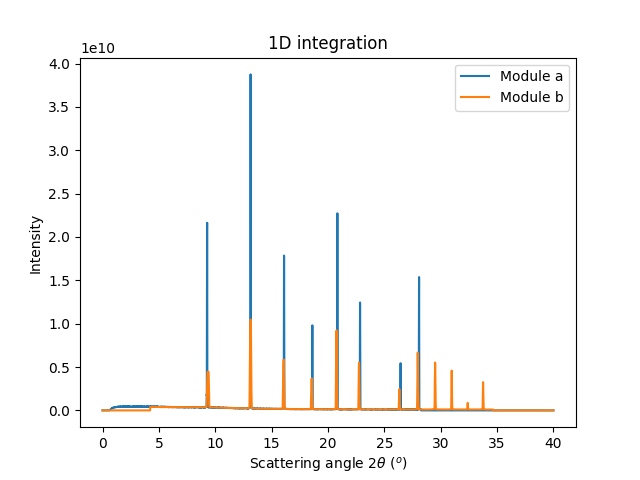

In [26]:
fig, ax = subplots()

mga = gonio_a.get_mg(ac)
mgb = gonio_b.get_mg(ac)
mga.radial_range=(0,40)
mgb.radial_range=(0,40)
images = [numpy.atleast_2d(i) for i in ds]
resa = mga.integrate1d(images, 10000)
resb = mgb.integrate1d(images, 10000)
from pyFAI.gui import jupyter
jupyter.plot1d(resa, ax=ax, label="Module a")
jupyter.plot1d(resb, ax=ax, label="Module b")

Let's do it again with the final mechanical setup.